In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.part2.tensorized_dp import TensorDP
from src.common.gridworld import GridworldEnv
from src.common.grid_visualization import visualize_value_function, visualize_policy

np.random.seed(0)

## `GridWorld` 초기화하기

가로로 `nx` 개, 세로로 `ny` 개의 칸을 가진 `GridworldEnv`를 만듭니다!

In [2]:
nx = 5
ny = 5
env = GridworldEnv([ny, nx])

## 동적계획법 '에이전트' 초기화하기

동적 게획법은 원래 `에이전트`라는 개념을 사용하지 않지만, 일반적으로 사용되는 강화학습의 구현 템플릿에 대한 이해를 돕기 위해 `에이전트`라는 개념을 적용하였습니다.

```python
class TensorDP:
    
    def __init__(self, gamma=1.0, error_tol=1e-5):
...        
```

`TensorDP` 클래스는 2개의 파라미터를 받습니다. 
감소율 `gamma` 와 가치평가/반복 알고리즘에서 수렴조건을 확인할 때 사용하는 수치적 에러의 허용치인 `error_tol` 입니다. 이 예제에서는 각각 `1.0` 과 `1e-5`로 설정하겠습니다.

In [3]:
dp_agent = TensorDP()

### DP agent에게 환경을 설정봅시다!

```python
def set_env(self, env, policy=None):
        self.env = env
        if policy is None:
            self.policy = np.ones([env.nS, env.nA]) / env.nA

        self.ns = env.nS
        self.na = env.nA
        self.P = env.P_tensor  # Rank 3 tensor [num. actions x num. states x num. states]
        self.R = env.R_tensor  # Rank 2 tensor [num. actions x num. states]

        print("Tensor DP agent initialized")
        print("Environment spec:  Num. state = {} | Num. actions = {} ".format(env.nS, env.nA))
```

In [4]:
dp_agent.set_env(env)

Tensor DP agent initialized
Environment spec:  Number of states: 25 | Number of actions: 4 


## `Numpy` 에서 텐서 연산

`Numpy` ,`Pytorch`, `Tensorflow` 등 많은 과학/공학연구를 위해 사용되는 라이브러리들은 많은 경우 효율적인 연산을 위해서 데이터를 tensor 의 형태로 표현합니다.특히, `Numpy` ,`Pytorch`, `Tensorflow`의 텐서 연산은 하드웨어 및 소프트웨어 수준에서 효율적 계산을 위해 많은 최적화 기법들이 적용되어 있기 때문에, `loop`를 활용한 계산보다 훨씬 더 빠른 속도로 연산이 가능합니다.

Deep learning 의 경우 또한, 현대적인 인공신경망 라이브러리인 `Pytorch`, `Tensorflow` 를 활용해서
인공신경망 내부의 연산을 텐서 연산으로 표현하고 그 연산을 매우 효율적으로 진행하기 위해 그래픽카드를 활용해 연산을 진행합니다. 따라서, 강화학습을 수강하시고 있는 여러분들도 텐서연산에 익숙해지시는게 앞으로 연구/개발 건강에 이롭습니다.

## Tensorized 정책 평가 (Policy evaluation)

Tensorized syncrhonous Policy evaluation 에 대해서 알아봅시다.

정책 평가 알고리즘은 Bellman expectation backup operator $T$ 가 수렴할때까지 반복하여, 현재 정책함수 $\pi$ 에 대한 주어진 MDP의 가치함수인 $V^{\pi}$ 를 찾는 알고리즘입니다. Bellman expectation backup operator $T$ 는 다음과 같이 정의됩니다.
$$T^{\pi}(V) \leftarrow R^{\pi} + \gamma P^{\pi} V$$ 

$\gamma$ 는 감가율, $R^{\pi}$ 는 정책 $\pi$ 에 대한 보상함수, $P^{\pi}$ 는 정책 $\pi$ 에 대한 상태천이 행렬입니다. <br>

### $R^{\pi}$ 효율적으로 계산하기

MDP 강의에서 이야기했던대로, $R^{\pi}$ 는 다음과 같이 정의 됩니다.

$$R^{\pi}_s = \sum_{a \in \cal{A}} \pi(a|s) R_s^a $$

각 $R^{\pi}$의 각 원소 $R^{\pi}_s$ 위의 수식으로 정의되고 $R^{\pi}$ 은 모든 상태 $s$ 의 $R^{\pi}_s$를 열 벡터로 표현한 형태가 됩니다. $R^{\pi} \in \mathbb{R}^{|\cal{S}|}$. 

> 예제에서는 구현의 편의를 위해 열 벡터 (Rank1 텐서)에 하나의 축을 더하여 $R^{\pi} \in \mathbb{R}^{|\cal{S}|\times 1}$ 으로 표현하였습니다.

#### Numpy 를 활용해 위의 수식을 구현

```python
def get_r_pi(self, policy):
    r_pi = (policy * self.R).sum(axis=-1)  # [num. states x 1]
    return r_pi
```

In [5]:
policy = dp_agent.policy # [num. states x num. actions]
R = dp_agent.env.R_tensor # [num. states x num. actions]

In [6]:
print("Policy")
print(policy)

Policy
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]


In [7]:
print("Reward function")
print(R)

Reward function
[[ 0.  0.  0.  0.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [ 0.  0.  0.  0.]]


### * 오퍼레이터

`*` 오퍼레이터는 두개의 `Numpy` array 를 각 원소별로 곱합니다.

In [8]:
weigthed_R = policy * R # [num. states x num. actions]
print(weigthed_R)

[[ 0.    0.    0.    0.  ]
 [-0.25 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25]
 [-0.25 -0.25 -0.25 -0.25]
 [ 0.    0.    0.    0.  ]]


In [9]:
averaged_R = weigthed_R.sum(axis=-1)
print(averaged_R)

[ 0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  0.]


### $P^{\pi}$ 효율적으로 계산하기

$P^{\pi}$ 는 다음과 같이 정의 됩니다.

$$P^{\pi}_{ss'} = \sum_{a \in \cal{A}} \pi(a|s) P_{ss'}^a $$

각 $P^{\pi}_{ss'}$는 상태천이 행렬 (이번에는 정말 행렬입니다!) 의 $s$번째 열(row) $s'$번째 행(column)의 원소입니다. 따라서 $P^{\pi} \in \mathbb{R}^{|\cal{S}|\times|\cal{S}|}$는 행렬입니다.
위의 수식을 도식화해서 표현하면 다음과 같은 그림이 됩니다.

<img src="./images/tensorized_p_computation.png" width="80%" height="50%" title="px(픽셀) 크기 설정" alt="Tensor"></img>

눈치가 좋으신분들은 (그래서 여러분들은) 아마도 이 연산이 기존의 매트릭스 곱하기 및 원소별 곱하기 (element-wise product, aka, Hadamard product) 등으로는 표현하기에 까다롭다는것을 알아채셨으리라 생각합니다. 이런 경우에 사용할수 있는 텐서연산 기법이 있습니다.

`아인슈타인 합`을 활용하면 우리가 원하는 연산을 간단하게 1줄로 표현할 수 있습니다.
`아인슈타인 합` 대부분의 텐서연산 라이브러리에서 __똑같은 문법으로__ 사용할수 있게 구현되어있습니다.
즉, 여러분이 `numpy`에서 아인슈타인 합으로 표현한 수식은 `pytorch`에서도 동일하게 사용할 수 있다는 이점이있습니다. 또한 `아인슈타인 합` 또한 매우 최적화된 방법으로 실행됩니다. 여러분들이 차후에 자신만의 알고리즘을 만들때도 `아인슈타인 합`으로 연산을 정의할 수 있다면, 꼭 한번 아인슈타인 합으로 표현해보도록 하세요.

```python
def get_p_pi(self, policy):
    p_pi = np.einsum("ik, kij -> ij", policy, self.P)  # [num. states x num. states]
    return p_pi
```

### 랜덤정책 $\pi$ 에 대한 $P^{\pi}$ 확인해보기

모든 상황에서 각 방향으로 움직일 확률이 0.25 인 정책 $\pi$ 의 $P^{\pi}$는?

In [10]:
df = pd.DataFrame(dp_agent.get_p_pi(dp_agent.policy))
df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.25,0.25,0.25,0.00,0.00,0.00,0.25,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.25,0.25,0.25,0.00,0.00,0.00,0.25,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.25,0.25,0.25,0.00,0.00,0.00,0.25,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.25,0.50,0.00,0.00,0.00,0.00,0.25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.25,0.00,0.00,0.00,0.00,0.25,0.25,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.25,0.00,0.00,0.00,0.25,0.00,0.25,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.25,0.00,0.00,0.00,0.25,0.00,0.25,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.25,0.00,0.25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.25,0.25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## 드디어 정책 평가 알고리즘!

```python
def policy_evaluation(self, policy=None, v_init=None):
    """
    :param policy: policy to evaluate (optional)
    :param v_init: initial value 'guesstimation' (optional)
    :return: v_pi: value function of the input policy
    """
    if policy is None:
        policy = self.policy

    r_pi = self.get_r_pi(policy)  # [num. states x 1]
    p_pi = self.get_p_pi(policy)  # [num. states x num. states]

    if v_init is None:
        v_old = np.zeros(self.ns)
    else:
        v_old = v_init

    while True:
        # perform Bellman expectation backup
        v_new = r_pi + self.gamma * np.matmul(p_pi, v_old)

        # check convergence
        bellman_error = np.linalg.norm(v_new - v_old)
        if bellman_error <= self.error_tol:
            break
        else:
            v_old = v_new
    return v_new
```

## 랜덤 정책함수로 `dp_agent`의 정책 초기화하기

랜덤 정책함수로 `dp_agent` 의 정책함수를 초기화 하였습니다. 한번 확인해볼까요?

In [11]:
policy_state_dim = dp_agent.policy.shape[0]
policy_action_dim = dp_agent.policy.shape[1]
print("===== 정책함수 스펙 =====")
print("state dimension: {}".format(policy_state_dim))
print("action dimension: {} \n".format(policy_action_dim))

print("===== 정책함수 =====")
print(dp_agent.policy)

===== 정책함수 스펙 =====
state dimension: 25
action dimension: 4 

===== 정책함수 =====
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]


## 랜덤 정책함수 평가하기

앞서 정의한 `policy_evaluation()` 를 활용해 현재 정책인 랜덤 정책에 대한 가치 함수를 추산합니다.

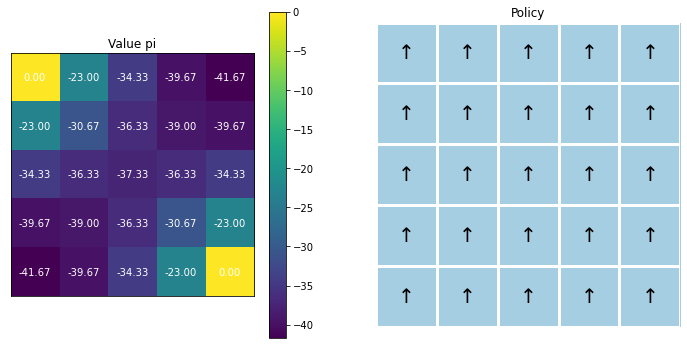

In [12]:
v_pi = dp_agent.policy_evaluation()
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], v_pi, nx, ny)
_ = ax[0].set_title("Value pi")
visualize_policy(ax[1], dp_agent.policy, nx, ny)
_ = ax[1].set_title("Policy")

v_old = v_pi # 정책 개선 정리에 대해 설명할때 사용

## "내 정책은 조금 전의 정책보다 개선된다!" 정책 개선

`policy_improvement()` 를 활용해 greedy policy improvement 를 수행합니다.

> Greedy 정책개선
> 1. $V^{\pi}(s)$ 와 $P$, $R$ 를 이용해 $Q^{\pi}(s,a)$ 를 계산한다. <br>
$$Q^\pi(s,a) = R_s^{a} + \gamma \Sigma_{s' \in \cal{S}}P_{ss'}^aV^{\pi}(s')$$

> 2. 개선된 정책 $\pi'(a|s)$ 을 가장 높은 $Q^{\pi}(s,a)$ 값을 주는 $a$ 에 대해서 1로 설정.
나머지는 0.0

파이썬 구현체를 한번 살펴보죠
```python
    def policy_improvement(self, policy=None, v_pi=None):
        if policy is None:
            policy = self.policy

        if v_pi is None:
            v_pi = self.policy_evaluation(policy)

        # (1) Compute Q_pi(s,a) from V_pi(s)
        r_pi = self.get_r_pi(policy)
        q_pi = r_pi + self.P.dot(v_pi)

        # (2) Greedy improvement
        policy_improved = np.zeros_like(policy)
        policy_improved[np.arange(q_pi.shape[1]), q_pi.argmax(axis=0)] = 1
        return policy_improved
```

> `policy_improved = np.zeros_like(policy)`  <br>
개선된 정책 $\pi'$ 는 선택될 action (특정 $s$ 에 대해 가장 큰 $Q(s,a)$를 만족하는 $a$) 이외에는 값이 0 이기 때문에 0으로 초기화 합니다.

> `policy_improved[np.arange(q_pi.shape[1]), q_pi.argmax(axis=0)] = 1` <br>
특정 $s$에 대해 가장 큰 $Q(s,a)$를 만족하는 $a$ 만을 1.0 으로 설정합니다.

In [15]:
r_pi = dp_agent.get_r_pi(policy)
r_pi

array([ 0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  0.])

In [16]:
v_pi

array([  0.        , -22.99995448, -34.33326343, -39.66658444,
       -41.66657955, -22.99995448, -30.66660512, -36.33325922,
       -38.99991957, -39.66658444, -34.33326343, -36.33325922,
       -37.33325708, -36.33325922, -34.33326343, -39.66658444,
       -38.99991957, -36.33325922, -30.66660512, -22.99995448,
       -41.66657955, -39.66658444, -34.33326343, -22.99995448,
         0.        ])

In [17]:
r_pi.shape

(25,)

In [18]:
v_pi.shape

(25,)

In [20]:
P = dp_agent.P
P.shape

(4, 25, 25)

In [26]:
r_pi

array([ 0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  0.])

In [25]:
P.dot(v_pi)

array([[  0.        , -22.99995448, -34.33326343, -39.66658444,
        -41.66657955,   0.        , -22.99995448, -34.33326343,
        -39.66658444, -41.66657955, -22.99995448, -30.66660512,
        -36.33325922, -38.99991957, -39.66658444, -34.33326343,
        -36.33325922, -37.33325708, -36.33325922, -34.33326343,
        -39.66658444, -38.99991957, -36.33325922, -30.66660512,
          0.        ],
       [  0.        , -34.33326343, -39.66658444, -41.66657955,
        -41.66657955, -30.66660512, -36.33325922, -38.99991957,
        -39.66658444, -39.66658444, -36.33325922, -37.33325708,
        -36.33325922, -34.33326343, -34.33326343, -38.99991957,
        -36.33325922, -30.66660512, -22.99995448, -22.99995448,
        -39.66658444, -34.33326343, -22.99995448,   0.        ,
          0.        ],
       [  0.        , -30.66660512, -36.33325922, -38.99991957,
        -39.66658444, -34.33326343, -36.33325922, -37.33325708,
        -36.33325922, -34.33326343, -39.66658444, -38.9999

In [28]:
r_pi + P.dot(v_pi)

array([[  0.        , -23.99995448, -35.33326343, -40.66658444,
        -42.66657955,  -1.        , -23.99995448, -35.33326343,
        -40.66658444, -42.66657955, -23.99995448, -31.66660512,
        -37.33325922, -39.99991957, -40.66658444, -35.33326343,
        -37.33325922, -38.33325708, -37.33325922, -35.33326343,
        -40.66658444, -39.99991957, -37.33325922, -31.66660512,
          0.        ],
       [  0.        , -35.33326343, -40.66658444, -42.66657955,
        -42.66657955, -31.66660512, -37.33325922, -39.99991957,
        -40.66658444, -40.66658444, -37.33325922, -38.33325708,
        -37.33325922, -35.33326343, -35.33326343, -39.99991957,
        -37.33325922, -31.66660512, -23.99995448, -23.99995448,
        -40.66658444, -35.33326343, -23.99995448,  -1.        ,
          0.        ],
       [  0.        , -31.66660512, -37.33325922, -39.99991957,
        -40.66658444, -35.33326343, -37.33325922, -38.33325708,
        -37.33325922, -35.33326343, -40.66658444, -39.9999

### Numpy 의 `argmax` 와 `advance indexing`

정책 개선을 구현하기 위해 조금 헷갈릴수 있는 트릭을 활용하였습니다. 본격적인 설명으로 넘어가기 전에
어떤 일이 벌어졌는지 예시를 들어 확인해보겠습니다. 
> 상태의 종류가 2개이고 가능한 행동이 3개인 간단한 MDP를 생각해봅시다.

In [14]:
Q = np.array([[1,2,3], [3,2,1]]) # [2 x 3] Q values.
print(Q)

[[1 2 3]
 [3 2 1]]


우리가 원하는것은 각 상태 $s$ (row) 에 대해 최댓값을 주는 행동 $a$의 index 입니다.

In [15]:
a_max = Q.argmax(axis=-1) # 마지막 축 (axis) 에 대해 argmax 를 구하면?
a_max # 파이썬은 숫자를 0부터 셉니다!

array([2, 0], dtype=int64)

In [16]:
policy_improved = np.zeros(shape=(2, 3))
print("Initialized policy")
print(policy_improved)

policy_improved[0, a_max[0]] = 1
print("set policy for the first state")
print(policy_improved)


policy_improved[1, a_max[1]] = 1
print("set policy for the second state")
print(policy_improved)

Initialized policy
[[0. 0. 0.]
 [0. 0. 0.]]
set policy for the first state
[[0. 0. 1.]
 [0. 0. 0.]]
set policy for the second state
[[0. 0. 1.]
 [1. 0. 0.]]


하지만 `numpy`의 indexing 을 활용하면 위의 코드를 한줄로 표현할수 있습니다.

In [17]:
policy_improved = np.zeros(shape=(2, 3))
print("Initialized policy")
print(policy_improved)

policy_improved[(0,1),(a_max[0],a_max[1])] = 1
print("Policy improvement")
print(policy_improved)

Initialized policy
[[0. 0. 0.]
 [0. 0. 0.]]
Policy improvement
[[0. 0. 1.]
 [1. 0. 0.]]


## Mini HW

`policy_improved[np.arange(q_pi.shape[1]), q_pi.argmax(axis=0)] = 1`를 실습 해보세요.

In [18]:
p_new = dp_agent.policy_improvement()
dp_agent.set_policy(p_new) # DP agent 의 정책을 개선된 정책 `p_new`로 설정

### 개선된 정책 확인하기

In [19]:
policy_state_dim = dp_agent.policy.shape[0]
policy_action_dim = dp_agent.policy.shape[1]
print("===== 정책함수 스펙 =====")
print("state dimension: {}".format(policy_state_dim))
print("action dimension: {} \n".format(policy_action_dim))

print("===== 정책함수 =====")
print(dp_agent.policy)

===== 정책함수 스펙 =====
state dimension: 25
action dimension: 4 

===== 정책함수 =====
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


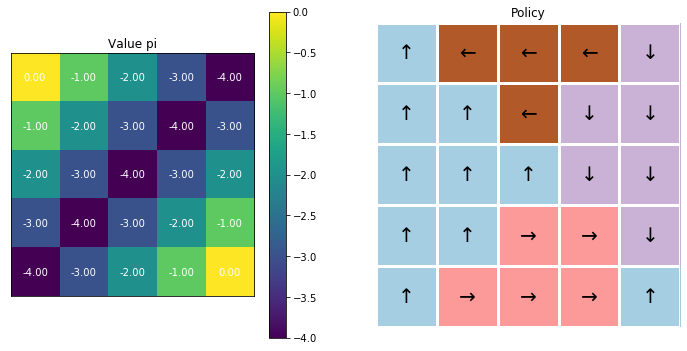

In [20]:
v_pi = dp_agent.policy_evaluation()
fig, ax = plt.subplots(1,2, figsize=(12,6))
visualize_value_function(ax[0], v_pi, nx, ny)
_ = ax[0].set_title("Value pi")
visualize_policy(ax[1], dp_agent.policy, nx, ny)
_ = ax[1].set_title("Policy")

v_new = v_pi # 개선된 정책에 대한 가치함수

## 정책개선 정리 결과 확인해보기

__정책개선 정리__ : 정책 개선 정리를 활용해 구해진 $\pi'$과 개선전 정책 $\pi$는 다음의 관계를 만족한다.
$$\pi' \geq \pi$$

$$\pi' \geq \pi \leftrightarrow V_{\pi'}(s) \geq V_{\pi}(s) \forall s \in S$$

In [21]:
delta_v = v_new - v_old

In [22]:
delta_v

array([ 0.        , 21.99995448, 32.33326343, 36.66658444, 37.66657955,
       21.99995448, 28.66660512, 33.33325922, 34.99991957, 36.66658444,
       32.33326343, 33.33325922, 33.33325708, 33.33325922, 32.33326343,
       36.66658444, 34.99991957, 33.33325922, 28.66660512, 21.99995448,
       37.66657955, 36.66658444, 32.33326343, 21.99995448,  0.        ])